In [173]:
import gym
from gym import spaces
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.colors import ListedColormap
import time


In [174]:

# Constants for cell states
EMPTY = 0
GOOD_GHOST_PLAYER = 1
BAD_GHOST_PLAYER = 2
GOOD_GHOST_OPPONENT = 3
BAD_GHOST_OPPONENT = 4
OPPONENT_CORNER = 5
PLAYER_CORNER = 6

# Reward structure
REACH_CORNER_REWARD = 100
CAPTURE_GOOD_GHOST_PENALTY = -50
CAPTURE_BAD_GHOST_REWARD = 50
OPPONENT_CAPUTRE_YOUR_GOOD_GHOST_PENALTY = -50
OPPONENT_CAPUTRE_YOUR_BAD_GHOST_REWARD = 50
OPPONENT_CORNER_REWARD = -100

In [175]:


class GhostsEnv:
    def __init__(self):
        self.board = np.zeros((6, 6), dtype=int)
        self.ghost_positions = []
        self.current_phase = 'placement'
        self.current_turn = 1
        self.placement_count = 0
        self.previous_winning_positions = []
      
    def reset(self):
        self.board = np.zeros((6, 6), dtype=int)
        self.ghost_positions = []
        self.current_phase = 'placement'
        self.current_turn = 1
        self.placement_count = 0
        # Set corner states
        self.board[0, 0] = self.board[0, 5] = OPPONENT_CORNER
        self.board[5, 0] = self.board[5, 5] = PLAYER_CORNER
        return self.board
    
    def get_valid_actions(self):
        valid_actions = []
        if self.current_phase == 'placement':
            if self.current_turn == 1:  # Player's turn
                rows = [5, 4]
            else:  # Opponent's turn
                rows = [0, 1]
            
            for row in rows:
                for col in range(1, 5):
                    if self.board[row, col] == EMPTY:
                        valid_actions.append(4 * (row % 4) + (col - 1))
        else:  # Movement phase
            for i, (x, y) in enumerate(self.ghost_positions):
                if (self.current_turn == 1 and self.board[x, y] in [GOOD_GHOST, BAD_GHOST]) or \
                   (self.current_turn == 2 and self.board[x, y] in [GOOD_GHOST_OPPONENT, BAD_GHOST_OPPONENT]):
                    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        new_x, new_y = x + dx, y + dy
                        if 0 <= new_x < 6 and 0 <= new_y < 6 and self.board[new_x, new_y] == EMPTY:
                            valid_actions.append(i * 5 + [(-1, 0), (1, 0), (0, -1), (0, 1)].index((dx, dy)))
                    # Add capture action
                    for adj_x, adj_y in self.get_adjacent_positions((x, y)):
                        if (self.current_turn == 1 and self.board[adj_x, adj_y] in [GOOD_GHOST_OPPONENT, BAD_GHOST_OPPONENT]) or \
                           (self.current_turn == 2 and self.board[adj_x, adj_y] in [GOOD_GHOST, BAD_GHOST]):
                            valid_actions.append(i * 5 + 4)
                            break
        
        if not valid_actions:
            print("Warning: No valid actions available.")
            print("Current board state:")
            print(self.board)
            print(f"Current phase: {self.current_phase}")
            print(f"Current turn: {self.current_turn}")
            print(f"Placement count: {self.placement_count}")
            print(f"Ghost positions: {self.ghost_positions}")
        
        return valid_actions

    def step(self, action):
        if self.current_phase == 'placement':
            return self.placement_step(action)
        else:
            return self.movement_step(action)

    def placement_step(self, action):
        reward = 0
        row = 5 if action < 4 else 4 if self.current_turn == 1 else 0 if action < 4 else 1
        col = (action % 4) + 1
        
        if self.current_turn == 1:  # Player's turn
            ghost_type = GOOD_GHOST if self.placement_count < 4 else BAD_GHOST
        else:  # Opponent's turn
            ghost_type = GOOD_GHOST_OPPONENT if random.random() < 0.5 else BAD_GHOST_OPPONENT

        self.board[row, col] = ghost_type
        self.ghost_positions.append((row, col))
        reward = 10 if ghost_type in [GOOD_GHOST, GOOD_GHOST_OPPONENT] else 5
        self.placement_count += 1
        self.current_turn = 3 - self.current_turn

        if self.placement_count == 16:
            self.current_phase = 'movement'
            reward += self.reward_for_initial_position()

        return self.board, reward, False, {}

    def movement_step(self, action):
        ghost_index = action // 5
        direction = action % 5

        if direction == 4:  # Capture action
            return self.capture_ghost(ghost_index)
        else:
            return self.move_ghost(ghost_index, direction)

    def move_ghost(self, ghost_index, direction):
        current_pos = self.ghost_positions[ghost_index]
        new_pos = self.get_new_position(current_pos, direction)

        ghost_type = self.board[current_pos]
        self.board[current_pos] = EMPTY
        self.board[new_pos] = ghost_type
        self.ghost_positions[ghost_index] = new_pos

        reward, done = self.check_win_conditions()
        reward += MOVE_PENALTY

        self.current_turn = 3 - self.current_turn
        return self.board, reward, done, {}

    def capture_ghost(self, ghost_index):
        current_pos = self.ghost_positions[ghost_index]
        adjacent_positions = self.get_adjacent_positions(current_pos)

        for pos in adjacent_positions:
            if (self.current_turn == 1 and self.board[pos] in [GOOD_GHOST_OPPONENT, BAD_GHOST_OPPONENT]) or \
               (self.current_turn == 2 and self.board[pos] in [GOOD_GHOST, BAD_GHOST]):
                captured_ghost = self.board[pos]
                if captured_ghost in [BAD_GHOST_OPPONENT, BAD_GHOST]:
                    reward = CAPTURE_BAD_GHOST_REWARD
                else:
                    reward = CAPTURE_GOOD_GHOST_PENALTY
                self.board[pos] = EMPTY
                self.ghost_positions.remove(pos)
                done = self.check_win_conditions()[1]
                self.current_turn = 3 - self.current_turn
                return self.board, reward, done, {}

        return self.board, MOVE_PENALTY, False, {}

    def get_new_position(self, current_pos, direction):
        x, y = current_pos
        if direction == 0:  # Up
            return (x - 1, y)
        elif direction == 1:  # Down
            return (x + 1, y)
        elif direction == 2:  # Left
            return (x, y - 1)
        elif direction == 3:  # Right
            return (x, y + 1)

    def get_adjacent_positions(self, pos):
        x, y = pos
        return [(x + dx, y + dy) for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)] if 0 <= x + dx < 6 and 0 <= y + dy < 6]

    def check_win_conditions(self):
        if self.player_reaches_corner():
            self.store_winning_position()
            return REACH_CORNER_REWARD, True
        elif self.all_good_ghosts_captured():
            return CAPTURE_GOOD_GHOST_PENALTY, True
        return 0, False

    def player_reaches_corner(self):
        return self.board[0, 0] == GOOD_GHOST or self.board[0, 5] == GOOD_GHOST

    def all_good_ghosts_captured(self):
        return np.sum(self.board == GOOD_GHOST) == 0

    def reward_for_initial_position(self):
        if not self.previous_winning_positions:
            return 0
        similarity_score = sum(1 for current, previous in zip(self.ghost_positions, self.previous_winning_positions) if current == previous)
        return similarity_score * 2

    def store_winning_position(self):
        self.previous_winning_positions = self.ghost_positions.copy()

In [176]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class GhostsAgent:
    def __init__(self, env):
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(6*6, 13).to(self.device)  # 6x6 board flattened, 13 possible actions
        self.target_model = DQN(6*6, 13).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters())
        self.memory = deque(maxlen=10000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.update_target_every = 100
        self.episode_rewards = []

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state.flatten(), action, reward, next_state.flatten(), done))

    def act(self, state):
        valid_actions = self.env.get_valid_actions()
        if random.random() <= self.epsilon:
            return random.choice(valid_actions)
        state = torch.FloatTensor(state.flatten()).unsqueeze(0).to(self.device)
        q_values = self.model(state)
        valid_q_values = q_values[0, valid_actions]
        return valid_actions[torch.argmax(valid_q_values).item()]

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        current_q_values = self.model(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.target_model(next_states).max(1)[0].detach()
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = nn.MSELoss()(current_q_values, target_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, episodes):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        cmap = ListedColormap(['white', 'green', 'red', 'blue', 'yellow', 'purple', 'orange'])

        for episode in range(episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            steps = 0

            while not done:
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                self.remember(state, action, reward, next_state, done)

                # Visualize the game board
                ax1.clear()
                ax1.imshow(state, cmap=cmap, vmin=0, vmax=6)
                ax1.set_title(f"Episode {episode}, Step {steps}")
                for i in range(6):
                    for j in range(6):
                        ax1.text(j, i, str(int(state[i, j])), ha='center', va='center')

                # Plot rewards
                ax2.clear()
                ax2.plot(self.episode_rewards)
                ax2.set_title("Rewards per Episode")
                ax2.set_xlabel("Episode")
                ax2.set_ylabel("Total Reward")

                plt.draw()
                plt.pause(0.1)

                # Print detailed information
                print(f"Episode: {episode}, Step: {steps}")
                print(f"Action: {action}")
                print(f"Reward: {reward}")
                print("Current State:")
                print(state)
                print("Next State:")
                print(next_state)
                print(f"Done: {done}")
                print("-------------------")

                state = next_state
                total_reward += reward
                steps += 1

                if len(self.memory) > self.batch_size:
                    self.replay()

            self.episode_rewards.append(total_reward)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            if episode % self.update_target_every == 0:
                self.target_model.load_state_dict(self.model.state_dict())

            print(f"Episode {episode} finished. Total Reward: {total_reward}, Steps: {steps}, Epsilon: {self.epsilon:.4f}")
            time.sleep(1)  # Pause between episodes

        plt.close()
        print("Training completed.")

    def visualize_training(self):
        episodes = len(self.episode_rewards)
        plt.figure(figsize=(12, 6))
        plt.plot(range(episodes), self.episode_rewards)
        plt.title('Reward per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.show()

        avg_reward = sum(self.episode_rewards) / episodes
        max_reward = max(self.episode_rewards)
        min_reward = min(self.episode_rewards)

        print(f"Average Reward: {avg_reward:.2f}")
        print(f"Max Reward: {max_reward}")
        print(f"Min Reward: {min_reward}")

        plt.figure(figsize=(12, 6))
        plt.hist(self.episode_rewards, bins=50)
        plt.title('Distribution of Rewards')
        plt.xlabel('Reward')
        plt.ylabel('Frequency')
        plt.show()

        window_size = 100
        moving_avg = np.convolve(self.episode_rewards, np.ones(window_size)/window_size, mode='valid')
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(moving_avg)), moving_avg)
        plt.title(f'Moving Average of Rewards (Window Size: {window_size})')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.show()

    def evaluate(self, episodes):
        total_rewards = []
        for episode in range(episodes):
            state = self.env.reset()
            done = False
            episode_reward = 0

            while not done:
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                state = next_state
                episode_reward += reward

                self.env.render_board()
                print(f"Action: {action}, Reward: {reward}")

            total_rewards.append(episode_reward)
            print(f"Episode {episode + 1} finished with total reward: {episode_reward}")

        avg_reward = sum(total_rewards) / episodes
        print(f"Average Reward over {episodes} episodes: {avg_reward:.2f}")
        return avg_reward

    def play_games(self, num_games=1, human_player=False):
        total_rewards = []
        for i in range(num_games):
            print(f"\nGame {i+1}")
            state = self.env.reset()
            done = False
            total_reward = 0
            
            while not done:
                self.env.render_board()
                
                if human_player and self.env.current_turn == 1:
                    action = self.env.get_human_action()
                else:
                    action = self.act(state)
                
                next_state, reward, done, _ = self.env.step(action)
                total_reward += reward
                
                print(f"Action: {action}, Reward: {reward}")
                
                state = next_state
                self.env.current_turn = 3 - self.env.current_turn  # Switch turns (1 -> 2, 2 -> 1)
            
            self.env.render_board()
            print(f"Game Over! Total Reward: {total_reward}")
            total_rewards.append(total_reward)
        
        avg_reward = sum(total_rewards) / num_games
        print(f"\nAverage Reward over {num_games} games: {avg_reward:.2f}")

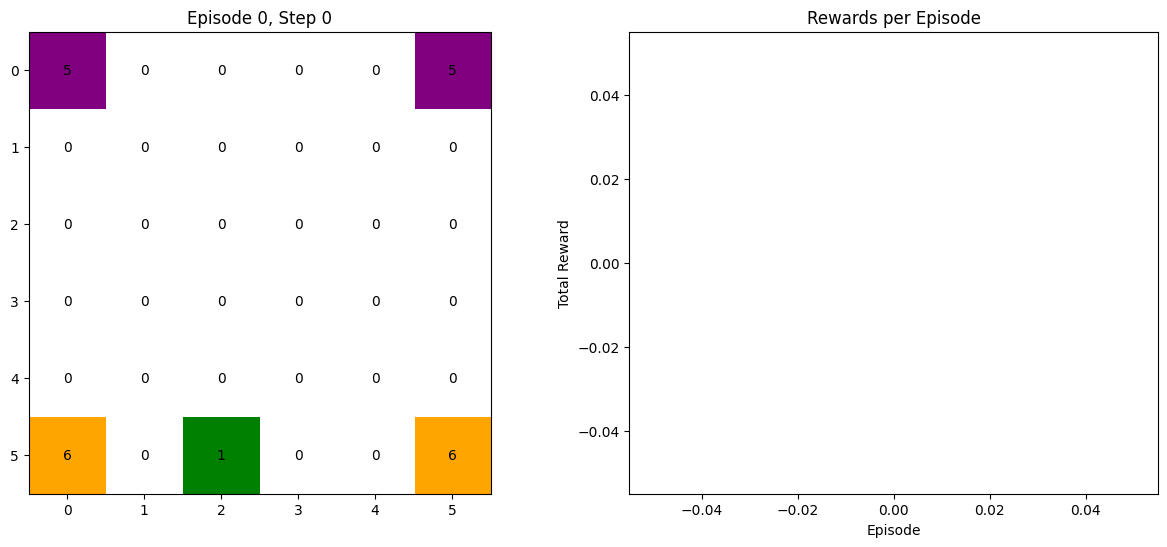

Episode: 0, Step: 0
Action: 1
Reward: 10
Current State:
[[5 0 0 0 0 5]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [6 0 1 0 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [6 0 1 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 0, Step: 1
Action: 5
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [6 0 1 0 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [6 0 1 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 0, Step: 2
Action: 2
Reward: 10
Current State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [6 0 1 1 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [6 0 1 1 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 0, Step: 3
Action: 1
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [6 0 4 1 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [6 0 4 1 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 0, Step: 4
Action: 7
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 0 4 1 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 0 4 1 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 0, Step: 5
Action: 1
Reward: 10
Current State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 0 3 1 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 0 3 1 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 0, Step: 6
Action: 1
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 0 2 1 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 0 2 1 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 0, Step: 7
Action: 0
Reward: 10
Current State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 3 2 1 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 3 2 1 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 0, Step: 8
Action: 0
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 2 1 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 2 1 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 0, Step: 9
Action: 2
Reward: 10
Current State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 2 3 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 2 3 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 0, Step: 10
Action: 2
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 2 2 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 2 2 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 0, Step: 11
Action: 1
Reward: 10
Current State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 3 2 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 3 2 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 0, Step: 12
Action: 0
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 3 2 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 3 2 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 0, Step: 13
Action: 1
Reward: 10
Current State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 3 2 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 3 2 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 0, Step: 14
Action: 0
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 3 2 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 4 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 3 2 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 0, Step: 15
Action: 7
Reward: 10
Current State:
[[5 0 0 0 0 5]
 [0 0 4 0 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 3 2 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 4 0 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 3 2 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 0, Step: 16
Action: 74
Reward: -50
Current State:
[[5 0 0 0 0 5]
 [0 0 4 0 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 0 2 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 4 0 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [6 2 0 2 0 6]]
Done: True
-------------------
Episode 0 finished. Total Reward: 70, Steps: 17, Epsilon: 0.9950


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 0
Action: 5
Reward: 10
Current State:
[[5 0 0 0 0 5]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [6 0 0 0 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [6 0 0 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 1
Action: 2
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [6 0 0 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [6 0 0 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 2
Action: 5
Reward: 10
Current State:
[[5 0 0 0 0 5]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [6 0 0 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [6 0 0 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 3
Action: 1
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [6 0 4 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [6 0 4 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 4
Action: 7
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 2 0]
 [6 0 4 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 2 0]
 [6 0 4 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 5
Action: 7
Reward: 10
Current State:
[[5 0 0 0 0 5]
 [0 0 0 0 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 2 0]
 [6 0 4 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 0 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 2 0]
 [6 0 4 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 6
Action: 4
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 0 0 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 4 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 0 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 4 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 7
Action: 1
Reward: 10
Current State:
[[5 0 0 0 0 5]
 [0 0 0 0 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 3 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 0 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 3 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 8
Action: 4
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 0 0 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 3 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 0 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 3 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 9
Action: 6
Reward: 10
Current State:
[[5 0 0 0 0 5]
 [0 0 0 3 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 3 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 3 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 3 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 10
Action: 7
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 0 3 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 3 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 3 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 3 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 11
Action: 1
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 0 3 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 4 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 3 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 4 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 12
Action: 4
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 0 3 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 4 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 3 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 4 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 13
Action: 3
Reward: 10
Current State:
[[5 0 0 0 0 5]
 [0 0 0 3 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 4 4 3 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 3 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 4 4 3 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 14
Action: 4
Reward: 5
Current State:
[[5 0 0 0 0 5]
 [0 0 0 3 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 4 4 3 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 3 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 4 4 3 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 15
Action: 4
Reward: 10
Current State:
[[5 0 0 0 0 5]
 [0 3 0 3 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 4 4 3 6]]
Next State:
[[5 0 0 0 0 5]
 [0 3 0 3 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 1 0 2 0]
 [6 0 4 4 3 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 16
Action: 70
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 3 0 3 3 0]
 [0 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 0 2 0]
 [6 0 4 4 3 6]]
Next State:
[[5 0 0 0 0 5]
 [0 3 0 3 3 0]
 [0 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 0 2 0]
 [6 0 4 4 3 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 17
Action: 5
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 3 0 3 3 0]
 [0 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 4 2 0]
 [6 0 4 0 3 6]]
Next State:
[[5 0 0 0 0 5]
 [0 3 0 3 3 0]
 [0 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 4 2 0]
 [6 0 4 0 3 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 18
Action: 24
Reward: -50
Current State:
[[5 0 0 0 0 5]
 [0 3 0 3 3 0]
 [0 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 4 2 0]
 [6 0 4 0 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 3 0 3 3 0]
 [0 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 4 2 0]
 [6 0 4 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 19
Action: 71
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 0 3 3 0]
 [0 3 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 4 2 0]
 [6 0 4 0 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 3 3 0]
 [0 3 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 4 2 0]
 [6 0 4 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 20
Action: 20
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 0 3 3 0]
 [0 3 0 0 0 0]
 [0 2 0 0 2 0]
 [0 0 1 4 0 0]
 [6 0 4 0 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 3 3 0]
 [0 3 0 0 0 0]
 [0 2 0 0 2 0]
 [0 0 1 4 0 0]
 [6 0 4 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 21
Action: 47
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 3 0 3 0]
 [0 3 0 0 0 0]
 [0 2 0 0 2 0]
 [0 0 1 4 0 0]
 [6 0 4 0 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 3 0 3 0]
 [0 3 0 0 0 0]
 [0 2 0 0 2 0]
 [0 0 1 4 0 0]
 [6 0 4 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 22
Action: 12
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 3 0 3 0]
 [0 3 0 0 0 0]
 [0 2 0 0 2 0]
 [0 1 0 4 0 0]
 [6 0 4 0 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 3 0 3 0]
 [0 3 0 0 0 0]
 [0 2 0 0 2 0]
 [0 1 0 4 0 0]
 [6 0 4 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 23
Action: 26
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 3 0 0 3 0]
 [0 2 0 0 2 0]
 [0 1 0 4 0 0]
 [6 0 4 0 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 3 0 0 3 0]
 [0 2 0 0 2 0]
 [0 1 0 4 0 0]
 [6 0 4 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 24
Action: 33
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 3 0 0 3 0]
 [0 2 0 0 2 0]
 [0 0 1 4 0 0]
 [6 0 4 0 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 3 0 0 3 0]
 [0 2 0 0 2 0]
 [0 0 1 4 0 0]
 [6 0 4 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 25
Action: 73
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 0 3 0 3 0]
 [0 2 0 0 2 0]
 [0 0 1 4 0 0]
 [6 0 4 0 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 0 3 0 3 0]
 [0 2 0 0 2 0]
 [0 0 1 4 0 0]
 [6 0 4 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 26
Action: 4
Reward: 50
Current State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 0 3 0 3 0]
 [0 2 0 0 2 0]
 [0 0 1 4 0 0]
 [6 0 0 0 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 0 3 0 3 0]
 [0 2 0 0 2 0]
 [0 0 1 4 0 0]
 [6 0 0 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 27
Action: 6
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 0 3 0 3 0]
 [0 2 0 0 2 0]
 [0 0 1 0 0 0]
 [6 0 0 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 0 3 0 3 0]
 [0 2 0 0 2 0]
 [0 0 1 0 0 0]
 [6 0 0 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 28
Action: 2
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 0 3 0 3 0]
 [0 2 0 0 2 0]
 [0 1 0 0 0 0]
 [6 0 0 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 0 3 0 3 0]
 [0 2 0 0 2 0]
 [0 1 0 0 0 0]
 [6 0 0 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 29
Action: 66
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 0 0 0 3 0]
 [0 2 3 0 2 0]
 [0 1 0 0 0 0]
 [6 0 0 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 0 0 0 3 0]
 [0 2 3 0 2 0]
 [0 1 0 0 0 0]
 [6 0 0 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 30
Action: 60
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 2 0 0 3 0]
 [0 0 3 0 2 0]
 [0 1 0 0 0 0]
 [6 0 0 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 2 0 0 3 0]
 [0 0 3 0 2 0]
 [0 1 0 0 0 0]
 [6 0 0 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 31
Action: 22
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 2 0 3 0 0]
 [0 0 3 0 2 0]
 [0 1 0 0 0 0]
 [6 0 0 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 2 0 3 0 0]
 [0 0 3 0 2 0]
 [0 1 0 0 0 0]
 [6 0 0 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 32
Action: 35
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 2 0 3 0 0]
 [0 1 3 0 2 0]
 [0 0 0 0 0 0]
 [6 0 0 4 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 2 0 3 0 0]
 [0 1 3 0 2 0]
 [0 0 0 0 0 0]
 [6 0 0 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 33
Action: 40
Reward: -1
Current State:
[[5 0 3 0 0 5]
 [0 0 0 0 0 0]
 [0 2 0 3 0 0]
 [0 1 3 0 2 0]
 [0 0 0 0 0 0]
 [6 0 0 4 0 6]]
Next State:
[[5 0 3 0 0 5]
 [0 0 0 0 0 0]
 [0 2 0 3 0 0]
 [0 1 3 0 2 0]
 [0 0 0 0 0 0]
 [6 0 0 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 34
Action: 18
Reward: -1
Current State:
[[5 0 3 0 0 5]
 [0 0 0 0 0 0]
 [0 2 0 3 0 0]
 [0 1 3 0 0 2]
 [0 0 0 0 0 0]
 [6 0 0 4 0 6]]
Next State:
[[5 0 3 0 0 5]
 [0 0 0 0 0 0]
 [0 2 0 3 0 0]
 [0 1 3 0 0 2]
 [0 0 0 0 0 0]
 [6 0 0 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 35
Action: 22
Reward: -1
Current State:
[[5 0 3 0 0 5]
 [0 0 0 0 0 0]
 [0 2 3 0 0 0]
 [0 1 3 0 0 2]
 [0 0 0 0 0 0]
 [6 0 0 4 0 6]]
Next State:
[[5 0 3 0 0 5]
 [0 0 0 0 0 0]
 [0 2 3 0 0 0]
 [0 1 3 0 0 2]
 [0 0 0 0 0 0]
 [6 0 0 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 36
Action: 39
Reward: -50
Current State:
[[5 0 3 0 0 5]
 [0 0 0 0 0 0]
 [0 2 3 0 0 0]
 [0 1 0 0 0 2]
 [0 0 0 0 0 0]
 [6 0 0 4 0 6]]
Next State:
[[5 0 3 0 0 5]
 [0 0 0 0 0 0]
 [0 2 3 0 0 0]
 [0 1 0 0 0 2]
 [0 0 0 0 0 0]
 [6 0 0 4 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 37
Action: 5
Reward: -1
Current State:
[[5 0 3 0 0 5]
 [0 0 0 0 0 0]
 [0 2 3 0 0 0]
 [0 1 0 0 0 2]
 [0 0 0 4 0 0]
 [6 0 0 0 0 6]]
Next State:
[[5 0 3 0 0 5]
 [0 0 0 0 0 0]
 [0 2 3 0 0 0]
 [0 1 0 0 0 2]
 [0 0 0 4 0 0]
 [6 0 0 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 38
Action: 36
Reward: -1
Current State:
[[5 0 3 0 0 5]
 [0 0 0 0 0 0]
 [0 2 3 0 0 0]
 [0 0 0 0 0 2]
 [0 1 0 4 0 0]
 [6 0 0 0 0 6]]
Next State:
[[5 0 3 0 0 5]
 [0 0 0 0 0 0]
 [0 2 3 0 0 0]
 [0 0 0 0 0 2]
 [0 1 0 4 0 0]
 [6 0 0 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 39
Action: 41
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 2 3 0 0 0]
 [0 0 0 0 0 2]
 [0 1 0 4 0 0]
 [6 0 0 0 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 2 3 0 0 0]
 [0 0 0 0 0 2]
 [0 1 0 4 0 0]
 [6 0 0 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 40
Action: 11
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 2 3 0 0 0]
 [0 0 0 0 0 2]
 [0 0 0 4 0 0]
 [6 1 0 0 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 3 0 0 0]
 [0 2 3 0 0 0]
 [0 0 0 0 0 2]
 [0 0 0 4 0 0]
 [6 1 0 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 41
Action: 40
Reward: -1
Current State:
[[5 0 3 0 0 5]
 [0 0 0 0 0 0]
 [0 2 3 0 0 0]
 [0 0 0 0 0 2]
 [0 0 0 4 0 0]
 [6 1 0 0 0 6]]
Next State:
[[5 0 3 0 0 5]
 [0 0 0 0 0 0]
 [0 2 3 0 0 0]
 [0 0 0 0 0 2]
 [0 0 0 4 0 0]
 [6 1 0 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 42
Action: 64
Reward: -50
Current State:
[[5 0 3 0 0 5]
 [0 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 0 0 0 2]
 [0 0 0 4 0 0]
 [6 1 0 0 0 6]]
Next State:
[[5 0 3 0 0 5]
 [0 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 0 0 0 2]
 [0 0 0 4 0 0]
 [6 1 0 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 43
Action: 38
Reward: -1
Current State:
[[5 0 0 3 0 5]
 [0 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 0 0 0 2]
 [0 0 0 4 0 0]
 [6 1 0 0 0 6]]
Next State:
[[5 0 0 3 0 5]
 [0 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 0 0 0 2]
 [0 0 0 4 0 0]
 [6 1 0 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 44
Action: 17
Reward: -1
Current State:
[[5 0 0 3 0 5]
 [0 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 0 0 2 0]
 [0 0 0 4 0 0]
 [6 1 0 0 0 6]]
Next State:
[[5 0 0 3 0 5]
 [0 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 0 0 2 0]
 [0 0 0 4 0 0]
 [6 1 0 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 45
Action: 36
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 0 3 0 0]
 [0 2 0 0 0 0]
 [0 0 0 0 2 0]
 [0 0 0 4 0 0]
 [6 1 0 0 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 3 0 0]
 [0 2 0 0 0 0]
 [0 0 0 0 2 0]
 [0 0 0 4 0 0]
 [6 1 0 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 46
Action: 57
Reward: -1
Current State:
[[5 0 0 0 0 5]
 [0 0 0 3 0 0]
 [2 0 0 0 0 0]
 [0 0 0 0 2 0]
 [0 0 0 4 0 0]
 [6 1 0 0 0 6]]
Next State:
[[5 0 0 0 0 5]
 [0 0 0 3 0 0]
 [2 0 0 0 0 0]
 [0 0 0 0 2 0]
 [0 0 0 4 0 0]
 [6 1 0 0 0 6]]
Done: False
-------------------


<Figure size 640x480 with 0 Axes>

Episode: 1, Step: 47
Action: 35
Reward: -1
Current State:
[[5 0 0 3 0 5]
 [0 0 0 0 0 0]
 [2 0 0 0 0 0]
 [0 0 0 0 2 0]
 [0 0 0 4 0 0]
 [6 1 0 0 0 6]]
Next State:
[[5 0 0 3 0 5]
 [0 0 0 0 0 0]
 [2 0 0 0 0 0]
 [0 0 0 0 2 0]
 [0 0 0 4 0 0]
 [6 1 0 0 0 6]]
Done: False
-------------------


RuntimeError: index 70 is out of bounds for dimension 1 with size 13

In [177]:
env = GhostsEnv()
agent = GhostsAgent(env)

# Train the agent
num_episodes = 4000
agent.train(episodes=num_episodes)

# Visualize the training results
agent.visualize_training()

# Evaluate the agent
eval_episodes = 100
agent.evaluate(episodes=eval_episodes)


In [83]:


# Play games
agent.play_games(num_games=5, human_player=True)


Game 1
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .

Action: 0, Reward: 10
. G . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .

Action: 3, Reward: 10
. G . . G .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .

Action: 1, Reward: 10
. G G . G .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .

Action: 2, Reward: 10
. G G G G .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .

Action: 5, Reward: 5
. G G G G .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . B . . .

Action: 4, Reward: 5
. G G G G .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. B B . . .

Action: 7, Reward: 5
. G G G G .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. B B . B .

Action: 6, Reward: 19
. G G G G .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. B B B B .

Action: 2, Reward: 99
G . G G G .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. B B B B .

Game Over! Total Reward: 173

Game 2
. . . . . .
. . . . . .
. . . 